<b>Imports</b>

In [1]:
from zephyrus_sc2_parser import parse_replay

# fancy packages
import pandas as p
import numpy as n
import seaborn as sns
import matplotlib.pyplot as plt

# necro packages
from IPython.core.display import HTML
import os
import traceback
import math
from random import randint
import time

<b>Variables</b>

In [2]:
# list of case sensitive user ids
# TODO: this would more reliable with the numerical player id isntaed of name
me_list_file='me_list.txt'
# list of paths where to look for replays
replay_dirs_file='replay_dirs_list.txt'

# column filters
global top_fields, unit_fields
top_fields=['gameloop', 'resource_collection_rate', 'unspent_resources','resource_collection_rate_all',
            'unit', 'building', 'upgrade', 'workers_active', 'workers_produced', 'workers_lost', 'supply',
            'supply_cap', 'supply_block', 'spm', 'army_value', 'resources_lost', 'resources_collected',
            'total_army_value', 'total_resources_lost', 'total_resources_collected', 'race', 'workers_killed']
unit_fields=['live', 'died', 'in_progress']

global me_list
with open(me_list_file) as f:
    me_list = [x.strip() for x in f.readlines()] 

with open(replay_dirs_file) as f:
    replay_dirs = [x.strip() for x in f.readlines()] 

<b>Main functions</b>

In [3]:
def timelines(replay):
    tls=[]
    hasme=False
    hasainame=0
    
    # make sure its 1v1
    if len(replay.players)!=2:
        return([])
    
    for pl in replay.players.values():
        pl.race=pl.race[0]
        
        pl.me=(pl.name in me_list)
        if pl.me:
            hasme=True

        hasainame+=('A.I.' in pl.name)
    
    # when game was played
    played_at=replay.metadata['played_at']
    
    # unique identifier
    map_name=replay.metadata['map']
    game_id='_'.join([
        map_name.replace(' ','_'),
        str(int((played_at.timestamp())))
    ])
    
    # game length in minutes
    gamelength=replay.metadata['game_length']/60#/22.4/60
    
    # kinda stupid but idk of any other way. seems to work
    custom=all(x is None for x in replay.summary['mmr'].values())
    vsai=custom and (hasainame>0)
    
    if replay.metadata['winner'] in replay.players:
        winner=replay.metadata['winner']
    else:
        winner=-1
    
    for i in replay.players.keys():
        keys=list(replay.players.keys())
        keys.remove(i)
        
        tl0=list(map(lambda x:x[i],replay.timeline))

        for j,x in enumerate(tl0):
            tl0[j]={y: x[y] for y in top_fields}
            
            for u in x['unit']:
                x['unit'][u]={y: x['unit'][u][y] for y in unit_fields}
                x['unit'][u]['built']=x['unit'][u]['live']+x['unit'][u]['died']
                
            for b in x['building']:
                x['building'][b]={y: x['building'][b][y] for y in unit_fields}
                x['building'][b]['built']=x['building'][b]['live']+x['building'][b]['died']
                # TODO: throwaway unnecessary buildings
            
            for u in x['upgrade']:
                tl0[j]['_'.join(['upgrade',u])]=1
                # TODO: this could be a little prettier, e.g. make each tiered set of upgrades
                # into single columns with values 1-3
                
            del tl0[j]['upgrade']
        
        tl=p.json_normalize(tl0,sep='_')  

        tl['player']=replay.players[i].name
        
        # NB can have blank MMR in general
        tl['mmr']=replay.summary['mmr'][i]
        
        race=replay.players[i].race
        opprace=replay.players[keys.pop()].race
        tl['race']=race
        tl['opprace']=opprace
        tl['matchup']='v'.join([race,opprace])
        
        tl['me']=replay.players[i].me
        
        tl['hasme']=hasme
        
        if winner<0:
            wl='?'
        elif i==winner:
            wl='W'
        else:
            wl='L'
        tl['wl']=wl
        
        tl['played_at']=played_at
        tl['map']=map_name
        tl['game_id']=game_id
        tl['custom']=custom
        tl['vsai']=vsai
        tl['gamelength']=gamelength

        # optional
        # TODO: check if observer
        # TODO: version of sc2
        # TODO: ranked or not (maybe check MMR? necessary?)
        
        tls+=[tl]

    return(tls)

# TODO: maybe it could take all replays after a certain date but that's pretty advanced
def go_thru_dir(dirpath):
    dfs=[]
    
    # should be in that folder only, not subfolders
    for filename in os.listdir(dirpath):
        if filename.lower().endswith('.sc2replay'):
            file=os.path.join(dirpath,filename)
            
            # otherwise it spits out a lot of errors and stuff
            try:
                # TODO: check local=False behavior
                replay=parse_replay(file)
            except:
                continue
                
            dfs+=timelines(replay)
            
    return(dfs)

<b>Main program</b>

In [4]:
t0 = time.time()

dfs=sum(map(go_thru_dir,replay_dirs),[])
print('{} replays processed'.format(len(dfs)))

df=p.concat(dfs,sort=False).reset_index()
print('Dataset formed with {} rows and {} columns'.format(len(df),len(df.columns)))

diffsec=time.time()-t0
tsec=int(diffsec%60)
tmin=int((diffsec-tsec)/60)
print('Took {} minutes and {} seconds'.format(tmin,tsec))

998 replays processed
Dataset formed with 102170 rows and 690 columns
Took 3 minutes and 41 seconds


<b>Check basic stuff</b>

In [5]:
#overview stats
df_games=df[(df.groupby(['game_id'])['gameloop'].transform(max)==df['gameloop']) & (df.me)]
print(df_games.groupby(['vsai']).size())
print(df_games[~df_games['vsai']].groupby(['matchup']).size())

# sanity check. note taht below potentially includes other players than you since you may have observed games vs AI 
print(df[(df['vsai']) & (~df['me'])]['player'].unique())

vsai
False    210
True     288
dtype: int64
matchup
PvP    67
PvT    75
PvZ    55
TvP     6
TvT     3
TvZ     2
ZvZ     2
dtype: int64
['A.I. 1 (Elite)' 'A.I. 1 (Very Easy)' 'A.I. 2 (Elite)' 'neptun']


<b>Example data science</b>

In [6]:
# basic slices
df_slice=df[
    (df['me']) & (~df['vsai']) & (df['gamelength']<60)
][[
    'game_id','gameloop','matchup','played_at','wl',
    'unit_Stalker_live','unit_Stalker_died',
    'unit_Disruptor_live','unit_Disruptor_died'
]].fillna(0)

# new fields
df_slice['unit_Stalker_built']=df_slice['unit_Stalker_live']+df_slice['unit_Stalker_died']
df_slice['unit_Disruptor_built']=df_slice['unit_Disruptor_live']+df_slice['unit_Disruptor_died']

# rescales time to [0,1]. idea was to use this for continuous alpha but seaborn does not support it :(
df_slice['unix']=df_slice['played_at'].apply(lambda x:float(x.timestamp()))
umax=df_slice['unix'].max()
umin=df_slice['unix'].min()
df_slice['unix_scale']=(df_slice['unix']-umin)/(umax-umin)

# minutes instead of game ticks
df_slice['min']=df_slice['gameloop']/22.4/60
df_slice['min2']=df_slice['min'].apply(math.floor)

In [7]:
# create aggregate datasets

# only one row per min2 in df_min2
min2_idx=df_slice.groupby(['game_id','min2'])['gameloop'].transform(max)==df_slice['gameloop']
# should cut out the outliers from here too
df_slice_min2=df_slice[(min2_idx)]

# only last row per game in df_slice_last
last_idx=df_slice.groupby(['game_id'])['gameloop'].transform(max)==df_slice['gameloop']
df_slice_last=df_slice[(last_idx)]

In [8]:
# melt for multi-unit plot
# could be prettier i guess
df_slice_min22=df_slice_min2[['game_id','min','min2','matchup','unix_scale','unit_Stalker_built','unit_Disruptor_built']].melt(
    id_vars=['game_id','min','min2','matchup','unix_scale'],
    var_name='unit',
    value_name='units_built'
)

<b>Plots</b>

In [9]:
len(df_slice_last[df_slice_last['matchup']=='PvP'])

66

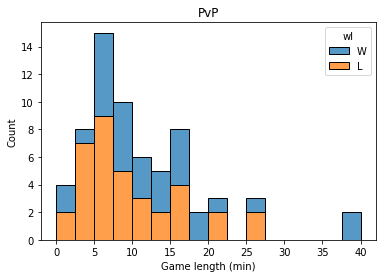

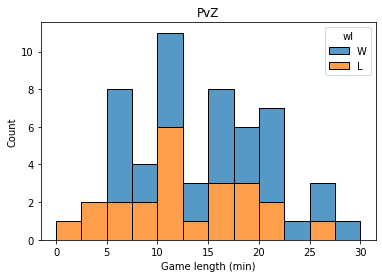

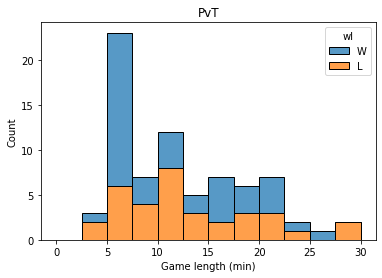

In [10]:
def histo_per_matchup(matchup):
    data=df_slice_last[df_slice_last['matchup']==matchup].sort_values('wl',ascending=False)
    gl_histo=sns.histplot(
        data=data,
        x='min2',
        hue='wl',
        binwidth=2.5,
        binrange=(0,data['min2'].max()),
        multiple='stack'
    )
    gl_histo.set(
        xlabel='Game length (min)',
        title=matchup
    )
    plt.show()
    
for mu in ['PvP','PvZ','PvT']:
    histo_per_matchup(mu)

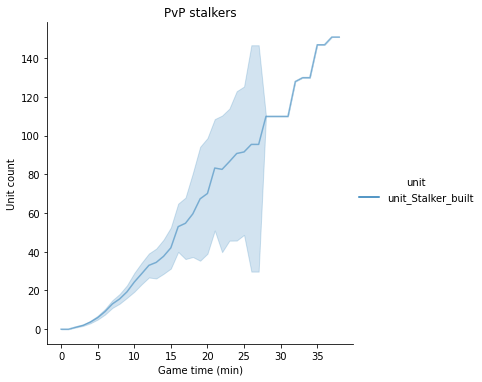

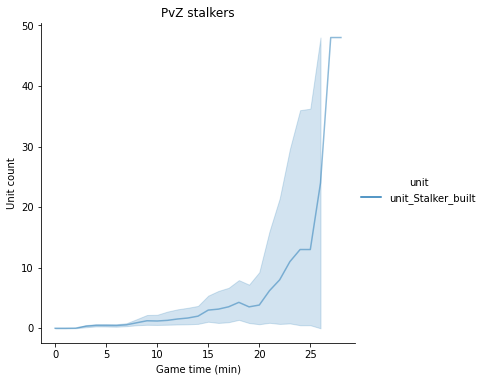

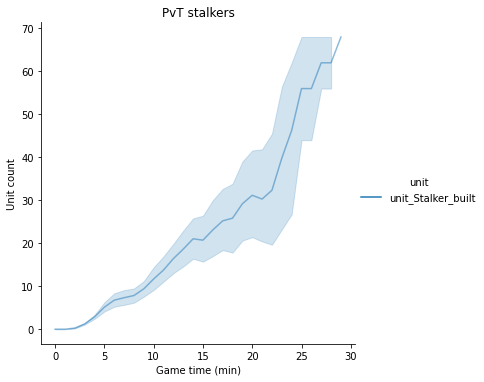

In [11]:
def units_per_matchup(matchup):
    rp_stalker=sns.relplot(
        data=df_slice_min22[
            (df_slice_min22['unit']=='unit_Stalker_built') & (df_slice_min22['matchup']==matchup)
        ],
        x='min2',
        y='units_built',
        alpha=0.5,
        hue='unit',
        kind='line'
    )
    rp_stalker.set(
        title=matchup+' stalkers',
        xlabel='Game time (min)',
        ylabel='Unit count'
    )

    plt.show()

for mu in ['PvP','PvZ','PvT']:
    units_per_matchup(mu)

<b>Debug stuff</b>

In [12]:
#debug

path = 'Deathaura LE (10).SC2Replay'

replay2 = parse_replay(path)

In [ ]:
replay2.timeline[-1][1]